In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
crimes = pd.read_csv('~/Downloads/cleaned_chicago_crime_data.csv')

In [4]:
crimes.index = crimes['ID'] # make the index the actual case number
# remove columns that are unnecessary for the analysis and would probably just slow our code down
crimes = crimes.drop(['Beat', 'FBI Code','Updated On', 'Case Number', 'Block', 'IUCR', 'ID', 'Unnamed: 0','Description', 'Ward', 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude'], axis=1)

In [5]:
crime_types = crimes['Primary Type'].unique().tolist()

### Begin cleaning data

1. Remove NaN values
2. standardize the crime type to get rid of the uppercase, standardize the non-criminal type
3. standardize the location description

There are actually no Nan values to remove! Government data is reliable I guess. The only NaN values are location, but we still know the district, so as long as we don't end up needing location later on, this is fine

In [6]:
to_drop = crimes[crimes.isnull().any(axis=1)]
to_drop;

In [7]:
def standardize_primary_type(string):
    # compile all non-criminal offenses into on label
    if string == 'NON-CRIMINAL (SUBJECT SPECIFIED)' or string == 'NON - CRIMINAL' or string == 'NON-CRIMINAL':
        return 'non-criminal'
    if string == 'OTHER OFFENSE':
        return 'other'
    # rename crim sexual assault to just sexual assault to make it easier to read
    if string == 'CRIM SEXUAL ASSAULT':
        return 'sexual assault'
    else:
        # everything else, make sure to lowercase it so we don't have to use caps lock lol
        return string.lower()
        

In [8]:
def standardize_location(string):
    if type(string) == str:
        string = string.lower()
        if 'airport' in string:
            return 'airport'
    return string

In [9]:
crimes['Primary Type'] = crimes['Primary Type'].apply(standardize_primary_type) # clean data 
crimes['location'] = crimes['Location Description'].apply(standardize_location)

In [10]:
# be careful if you run this one, only run it once it won't work the second time 
crimes = crimes.drop(['Location Description','Community Area'],axis=1)

In [11]:
crimes = crimes.rename(columns = {'Location': 'Coordinates'})

In [12]:
violents = ['BATTERY','ASSAULT','CRIM SEXUAL ASSAULT', 'ARSON','HOMICIDE']

In [13]:
violent_crimes = crimes[ (crimes['Primary Type'] == 'battery') | (crimes['Primary Type'] == 'assault') | (crimes['Primary Type'] == 'sexual assault') | (crimes['Primary Type'] == 'arson') | (crimes['Primary Type'] == 'homicide')]

In [14]:
crimes.head()

,Date,Primary Type,Arrest,Domestic,District,Year,Coordinates,location
ID,,,,,,,,
10000092,03/18/2015 07:44:00 PM,battery,False,False,11.0,2015,"(41.891398861, -87.744384567)",street
10000094,03/18/2015 11:00:00 PM,other,True,False,7.0,2015,"(41.773371528, -87.665319468)",street
10000095,03/18/2015 10:45:00 PM,battery,False,True,2.0,2015,"(41.81386068, -87.596642837)",apartment
10000096,03/18/2015 10:30:00 PM,battery,False,False,2.0,2015,"(41.800802415, -87.622619343)",apartment
10000097,03/18/2015 09:00:00 PM,robbery,False,False,11.0,2015,"(41.878064761, -87.743354013)",sidewalk


## Overall, our question is, does the district a crime was committed in or the type of crime predict whether an arrest was made for that crime

First, I will fit a linear regression model to see how district predicts arrest rate.
1. Create a dataframe with index being the district, one column is the arrest rate for a particular crime, we will look at the top three crimes. 

In [15]:
top_three = crimes['Primary Type'].value_counts().nlargest(3)

In [16]:
top_three

theft              1431574
battery            1241925
criminal damage     776765
Name: Primary Type, dtype: int64

In [29]:
districts = crimes['District'].unique().tolist()
districts.remove(21)

In [18]:
district_cache = {}
for district in districts:
    district_cache[district] = crimes[ crimes['District'] == district ]

In [19]:
district_cache;

In [63]:
dist_pred_arrest = pd.DataFrame()
for district in districts:
    
    district_df = district_cache[district]
    
    arrest_occurred = district_df[district_df['Arrest'] == True]
    
    dist_pred_arrest.loc[district,'Reported Theft'] = len(district_df[district_df['Primary Type'] == 'theft'])
    dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] = len(arrest_occurred[arrest_occurred['Primary Type'] == 'theft'])
    dist_pred_arrest.loc[district,'Theft Arrest Rate'] = dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Theft']

    dist_pred_arrest.loc[district,'Reported Battery'] = len(district_df[district_df['Primary Type'] == 'battery'])
    dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] = len(arrest_occurred[arrest_occurred['Primary Type'] == 'battery'])
    dist_pred_arrest.loc[district,'Battery Arrest Rate'] = dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Battery']

    
    dist_pred_arrest.loc[district,'Reported Criminal Damage'] = len(district_df[district_df['Primary Type'] == 'criminal damage'])
    dist_pred_arrest.loc[district,'Criminal Damage w/ Arrest Made'] = len(arrest_occurred[arrest_occurred['Primary Type'] == 'criminal damage'])
    dist_pred_arrest.loc[district,'Criminal Damage Arrest Rate'] = dist_pred_arrest.loc[district,'Criminal Damage w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Criminal Damage']

    
    
    
    


In [64]:
dist_pred_arrest = dist_pred_arrest.sort_index().drop(21)

KeyError: '[21] not found in axis'

In [66]:
dist_pred_arrest

,Reported Theft,Theft w/ Arrest Made,Theft Arrest Rate,Reported Battery,Battery w/ Arrest Made,Battery Arrest Rate,Reported Criminal Damage,Criminal Damage w/ Arrest Made,Criminal Damage Arrest Rate
11.0,49428.0,4815.0,0.097414,86640.0,15599.0,0.180044,35622.0,2524.0,0.070855
7.0,53662.0,4489.0,0.083653,98871.0,18034.0,0.182399,44806.0,2993.0,0.066799
2.0,63662.0,7635.0,0.119930,65318.0,14094.0,0.215775,32448.0,2157.0,0.066476
9.0,60667.0,8157.0,0.134455,63572.0,14986.0,0.235733,44685.0,3689.0,0.082556
5.0,41843.0,3813.0,0.091126,69128.0,14803.0,0.214139,37722.0,2267.0,0.060098
6.0,68956.0,11746.0,0.170341,79824.0,17455.0,0.218669,42173.0,2775.0,0.065800
4.0,62682.0,5837.0,0.093121,79849.0,16098.0,0.201606,50630.0,2817.0,0.055639
12.0,94488.0,8693.0,0.092001,52123.0,13078.0,0.250907,39319.0,3005.0,0.076426
15.0,32080.0,2871.0,0.089495,62969.0,12963.0,0.205863,25260.0,2059.0,0.081512
14.0,75868.0,5926.0,0.078109,40357.0,10653.0,0.263969,33420.0,2734.0,0.081807


In [67]:
# want to predict whether an arrest was made from the district. So y is arrests, X is districts
y = dist_pred_arrest['Reported Theft']
X = districts
model = sm.OLS(y,X)
results = model.fit()

In [68]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Reported Theft   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     32.97
Date:                Tue, 12 Mar 2019   Prob (F-statistic):           1.06e-05
Time:                        00:06:31   Log-Likelihood:                -266.29
No. Observations:                  22   AIC:                             534.6
Df Residuals:                      21   BIC:                             535.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3877.7886    675.355      5.742      0.000    2473.311    5282.266
==============================================================================
Omnibus:                        0.136   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.934   Jarque-Bera (JB):                0.148
Skew:                           0.137   Prob(JB):                        0.929
Kurtosis:                       2.706   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

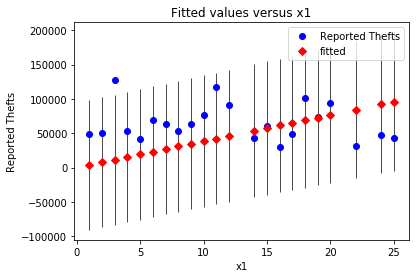

In [61]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(results, 0, ax=ax)

So all that proved is that there probably isn't a relationship between the value of the district and the number of reported thefts

Now, I'm going to find the arrest rate in each district

In [69]:
# want to predict whether an arrest was made from the district. So y is arrests, X is districts
y = dist_pred_arrest['Theft Arrest Rate']
X = districts
model = sm.OLS(y,X)
results = model.fit()

In [71]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Theft Arrest Rate   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     47.31
Date:                Tue, 12 Mar 2019   Prob (F-statistic):           8.48e-07
Time:                        00:06:47   Log-Likelihood:                 28.632
No. Observations:                  22   AIC:                            -55.26
Df Residuals:                      21   BIC:                            -54.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0070      0.001      6.878      0.000       0.005       0.009
==============================================================================
Omnibus:                        1.346   Durbin-Watson:                   1.469
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                1.109
Skew:                           0.512   Prob(JB):                        0.574
Kurtosis:                       2.599   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

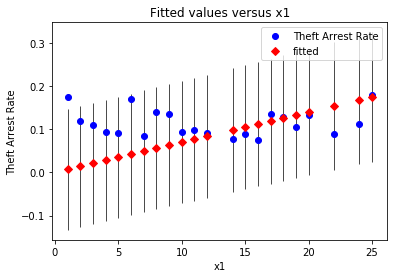

In [72]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(results, 0, ax=ax)

So I have shown that there is not likely a linear relationship between district and theft arrest rate - check on A3